Import Dependencies

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenetv2_preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Average, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint



import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

In [2]:
np.random.seed(123)

In [3]:
data_dir = '/kaggle/input/coviddataset-70-30/CovidDataset_70_30'

In [4]:
batch_size = 32
input_shape = (224, 224, 3)
num_classes = 2

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        os.path.join(data_dir, 'Train'),
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        os.path.join(data_dir, 'Test'),
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        os.path.join(data_dir, 'Validation'),
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical')

Found 5272 images belonging to 2 classes.
Found 1132 images belonging to 2 classes.
Found 1130 images belonging to 2 classes.


In [6]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

modelV19 = Sequential()
modelV19.add(vgg19)
modelV19.add(Flatten())
modelV19.add(Dense(500, activation='relu'))
modelV19.add(Dropout(0.5))
modelV19.add(Dense(300, activation='relu'))
modelV19.add(Dropout(0.5))
modelV19.add(Dense(num_classes, activation='softmax'))

for layer in vgg19.layers:
    layer.trainable = False
modelV19.summary()

80134624/80134624 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 500)               12544500  
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               150300    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                         

In [7]:
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

modelM2 = Sequential()
modelM2.add(mobilenetv2)
modelM2.add(Flatten())
modelM2.add(Dense(500, activation='relu'))
modelM2.add(Dropout(0.5))
modelM2.add(Dense(300, activation='relu'))
modelM2.add(Dropout(0.5))
modelM2.add(Dense(num_classes, activation='softmax'))

for layer in mobilenetv2.layers:
    layer.trainable = False
    
modelM2.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 500)               31360500  
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense_4 (Dense)             (None, 300)               150300    
                                                                 
 dropout_3 (Dropout)         (None, 300)               0 

In [19]:
opt = Adam(learning_rate=0.0001, beta_1=0.9)
modelV19.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])

modelM2.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10)
filepath_weights_V19 = "/kaggle/working/save_weights/best_weights_V19-{epoch:02d}-{val_accuracy:.4f}.hdf5"
filepath_weights_M2 = "/kaggle/working/save_weights/best_weights_M2-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint_V19 = ModelCheckpoint(filepath_weights_V19, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
checkpoint_M2 = ModelCheckpoint(filepath_weights_M2, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


In [20]:
# Dont run again model is saved @ /kaggle/working/save_weights/best_weights_V19-16-0.9451.hdf5

history_V19 = modelV19.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stop, checkpoint_V19])

Epoch 1/50
165/165 [==============================] - ETA: 0s - loss: 0.3109 - accuracy: 0.8649
Epoch 1: val_accuracy improved from -inf to 0.88673, saving model to /kaggle/working/save_weights/best_weights_V19-01-0.8867.hdf5
165/165 [==============================] - 80s 478ms/step - loss: 0.3109 - accuracy: 0.8649 - val_loss: 0.2798 - val_accuracy: 0.8867
Epoch 2/50
165/165 [==============================] - ETA: 0s - loss: 0.2963 - accuracy: 0.8780
Epoch 2: val_accuracy did not improve from 0.88673
165/165 [==============================] - 77s 467ms/step - loss: 0.2963 - accuracy: 0.8780 - val_loss: 0.2815 - val_accuracy: 0.8823
Epoch 3/50
165/165 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.8722
Epoch 3: val_accuracy improved from 0.88673 to 0.90354, saving model to /kaggle/working/save_weights/best_weights_V19-03-0.9035.hdf5
165/165 [==============================] - 77s 466ms/step - loss: 0.3019 - accuracy: 0.8722 - val_loss: 0.2430 - val_accuracy: 0.9

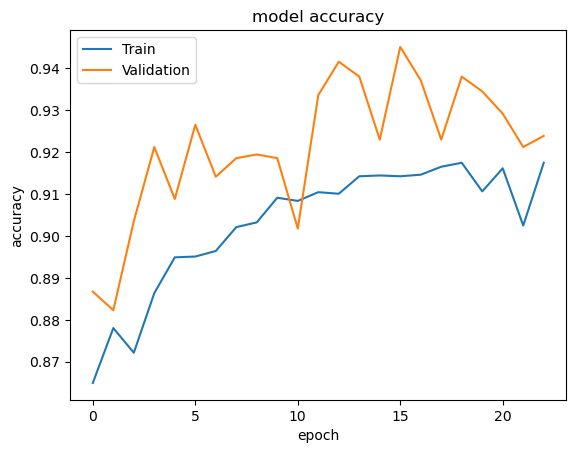

In [22]:
plt.plot(history_V19.history['accuracy'])
plt.plot(history_V19.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

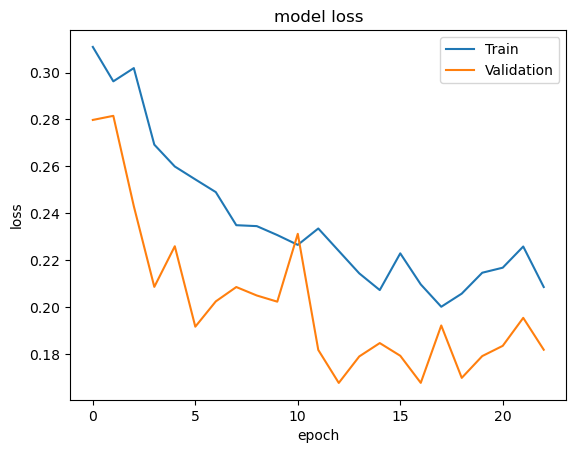

In [23]:
plt.plot(history_V19.history['loss'])
plt.plot(history_V19.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Dont run again model is saved @ /kaggle/working/save_weights/best_weights_M2-33-0.9575.hdf5
history_M2 = modelM2.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stop, checkpoint_M2])

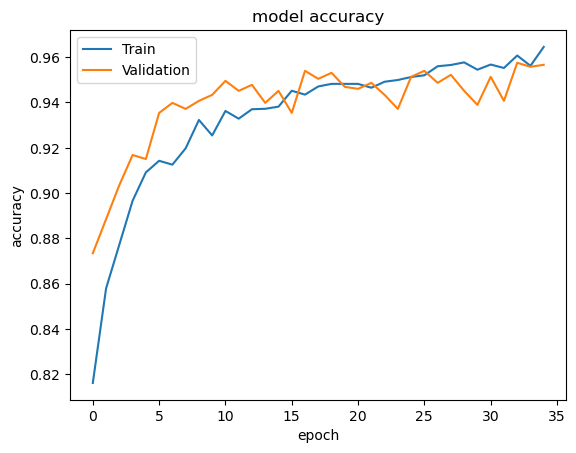

In [24]:
plt.plot(history_M2.history['accuracy'])
plt.plot(history_M2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

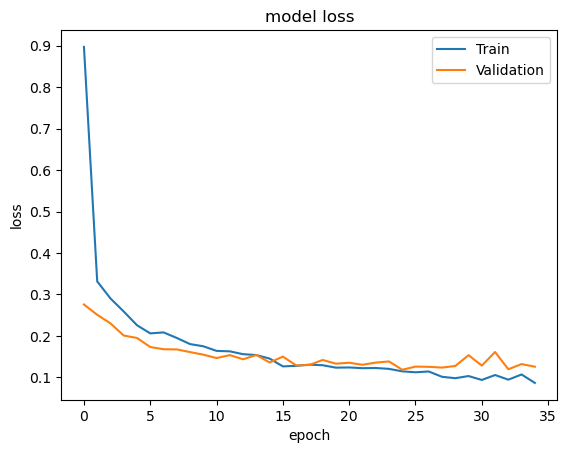

In [25]:
plt.plot(history_M2.history['loss'])
plt.plot(history_M2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [28]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average

model_1 = load_model('/kaggle/working/save_weights/best_weights_V19-16-0.9451.hdf5')
model_2 = load_model('/kaggle/working/save_weights/best_weights_M2-33-0.9575.hdf5')

model_1 = Model(
    inputs = model_1.inputs,
    outputs = model_1.outputs,
    name = "VGG16"
)

model_2 = Model(
    inputs = model_2.inputs,
    outputs = model_2.outputs,
    name = "MobileNetV2"
)

models = [model_1,model_2]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]

ensemble_output = Average()(model_outputs)
ensemble_model = Model(
    inputs = model_input,
    outputs = ensemble_output,
    name = "Ensemble"
)

ensemble_model.summary()

Model: "Ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 VGG16 (Functional)             (None, 2)            32719786    ['input_3[0][0]']                
                                                                                                  
 MobileNetV2 (Functional)       (None, 2)            33769386    ['input_3[0][0]']                
                                                                                                  
 average (Average)              (None, 2)            0           ['VGG16[0][0]',           

In [33]:
ensemble_model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])

filepath_weights_ensemble = "/kaggle/working/save_weights/best_weights_ensemble-{epoch:02d}-{val_accuracy:.4f}.tf"
checkpoint_ensemble = ModelCheckpoint(filepath_weights_ensemble, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [34]:
history_ensemble = ensemble_model.fit(train_generator, epochs=50, validation_data=validation_generator, callbacks=[early_stop, checkpoint_ensemble])

Epoch 1/50
165/165 [==============================] - ETA: 0s - loss: 0.2681 - accuracy: 0.8778
Epoch 1: val_accuracy improved from -inf to 0.91150, saving model to /kaggle/working/save_weights/best_weights_ensemble-01-0.9115.tf
165/165 [==============================] - 110s 646ms/step - loss: 0.2681 - accuracy: 0.8778 - val_loss: 0.2223 - val_accuracy: 0.9115
Epoch 2/50
165/165 [==============================] - ETA: 0s - loss: 0.2209 - accuracy: 0.9200
Epoch 2: val_accuracy improved from 0.91150 to 0.94071, saving model to /kaggle/working/save_weights/best_weights_ensemble-02-0.9407.tf
165/165 [==============================] - 107s 649ms/step - loss: 0.2209 - accuracy: 0.9200 - val_loss: 0.1853 - val_accuracy: 0.9407
Epoch 3/50
165/165 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9378
Epoch 3: val_accuracy improved from 0.94071 to 0.94956, saving model to /kaggle/working/save_weights/best_weights_ensemble-03-0.9496.tf
165/165 [============================

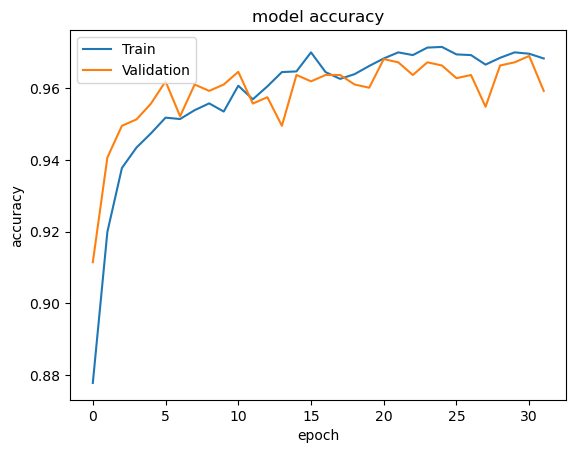

In [35]:
plt.plot(history_ensemble.history['accuracy'])
plt.plot(history_ensemble.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

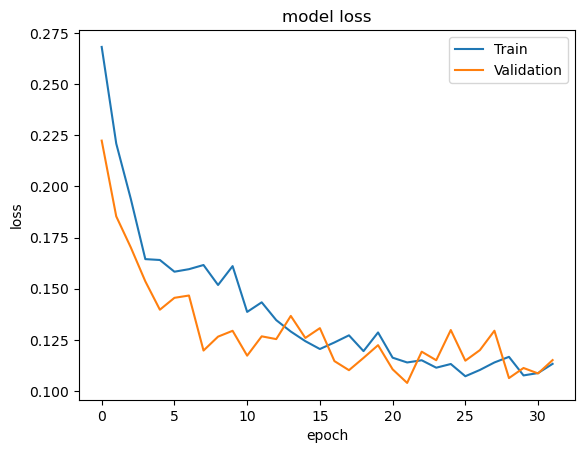

In [36]:
plt.plot(history_ensemble.history['loss'])
plt.plot(history_ensemble.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [38]:
ensemble_model.load_weights('/kaggle/working/save_weights/best_weights_ensemble-31-0.9690.tf')
test_loss, test_acc = ensemble_model.evaluate(test_generator)
print('Test accuracy:', test_acc)

36/36 [==============================] - 12s 345ms/step - loss: 0.0838 - accuracy: 0.9735
Test accuracy: 0.9734982252120972


In [40]:
ensemble_model.load_weights('/kaggle/working/save_weights/best_weights_ensemble-31-0.9690.tf')
y_pred = ensemble_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = test_generator.classes

36/36 [==============================] - 6s 142ms/step


In [41]:
print("Classification Report:\n",classification_report(y_true_classes, y_pred_classes))

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.48      0.48       566
           1       0.48      0.48      0.48       566

    accuracy                           0.48      1132
   macro avg       0.48      0.48      0.48      1132
weighted avg       0.48      0.48      0.48      1132



In [42]:
# Calculate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Extract TP, TN, FP, FN
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

# Calculate specificity
specificity = TN / (TN + FP)

# Calculate sensitivity
sensitivity = TP / (TP + FN)

# Calculate accuracy
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Calculate precision
precision = precision_score(y_true_classes, y_pred_classes)

# Calculate false positive rate (FPR)
FPR = FP / (FP + TN)

# Calculate false negative rate (FNR)
FNR = FN / (FN + TP)

# Calculate negative predictive value (NPV)
NPV = TN / (TN + FN)

# Calculate false discovery rate (FDR)
FDR = FP / (FP + TP)

# Calculate F1 score
f1_score = f1_score(y_true_classes, y_pred_classes)

# Calculate Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(y_true_classes, y_pred_classes)

# Print the metrics
print("Evaluation Metrics -\n")
print("Specificity: ", specificity)
print("Sensitivity: ", sensitivity)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("FPR: ", FPR)
print("FNR: ", FNR)
print("NPV: ", NPV)
print("FDR: ", FDR)
print("F1 Score: ", f1_score)
print("MCC: ", mcc)

Evaluation Metrics -

Specificity:  0.4752650176678445
Sensitivity:  0.4823321554770318
Accuracy:  0.4787985865724382
Precision:  0.4789473684210526
FPR:  0.5247349823321554
FNR:  0.5176678445229682
NPV:  0.4786476868327402
FDR:  0.5210526315789473
F1 Score:  0.4806338028169013
MCC:  -0.04240388578744298


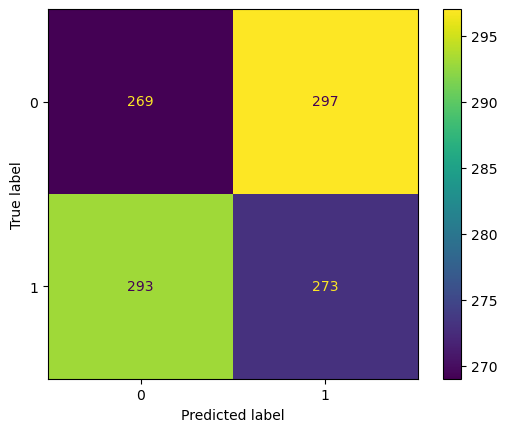

In [43]:
print(ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes))

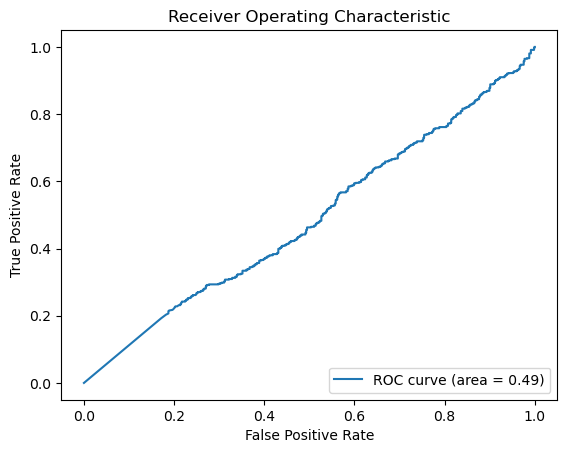

In [44]:
# Assuming you have binary classification with two classes, you can adjust accordingly for multi-class
fpr, tpr, _ = roc_curve(test_generator.classes, y_pred[:, 1])  # Use y_pred[:, 1] for positive class predictions
roc_auc = auc(fpr, tpr)

# Plot ROC curve for positive class
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

1/1 [==============================] - 1s 941ms/step


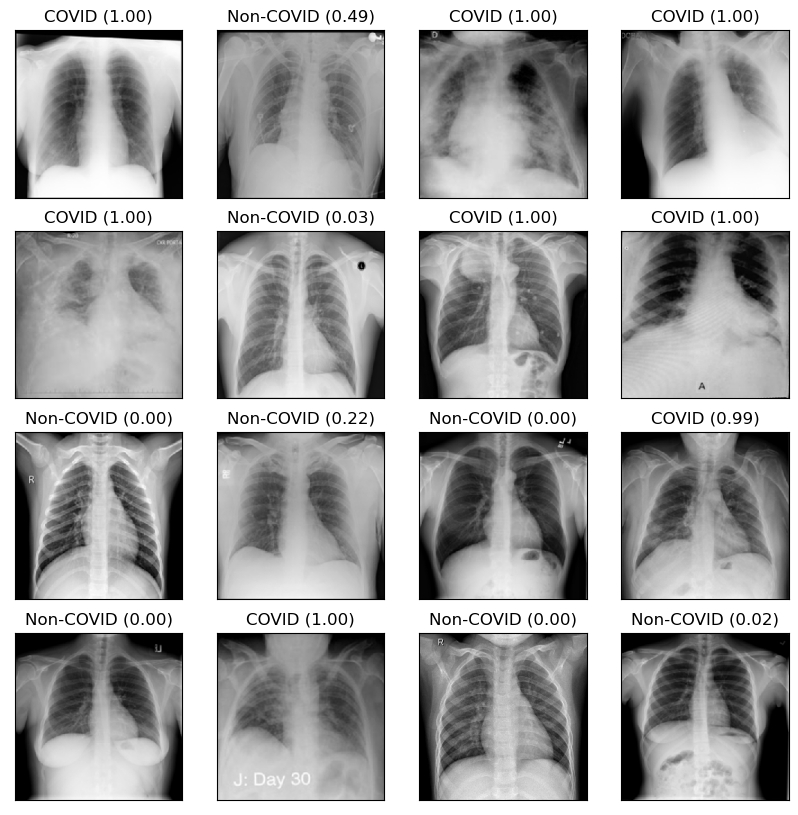

In [46]:
test_images, test_labels = next(test_generator)
test_pred = ensemble_model.predict(test_images)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    # Plot image
    ax.imshow(test_images[i])

    # Set the title
    if test_pred[i][0] > 0.5:
        title = f'COVID ({test_pred[i][0]:.2f})'
    else:
        title = f'Non-COVID ({test_pred[i][0]:.2f})'
    ax.set_title(title)

    # Remove ticks from the plot
    ax.set_xticks([])
    ax.set_yticks([])